# **0. 라이브러리 호출**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# **1. 데이터셋 구축**

## **1-1. 데이터셋 다운로드 및 전처리**

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST(
    root="../data", train=True, transform = transform, download = True)

test_dataset = datasets.MNIST(
    root="../data", train = False, transform = transform, download = True)

## **1-2. Dataloader에 데이터 전달**

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 64)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 64)

In [ ]:
### 데이터 형태 확인

for X, y in train_loader:
  print('Shape of X([N, C, H, W]): ',X.shape) # feature(image의 pixel)
  print('Shape of y: ',y.shape) # 해당하는 숫자(정답)
  break

print("Data size: ", len(train_loader))

Shape of X([N, C, H, W]):  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64])
Data size:  938


## **1-3. 샘플 데이터 확인**

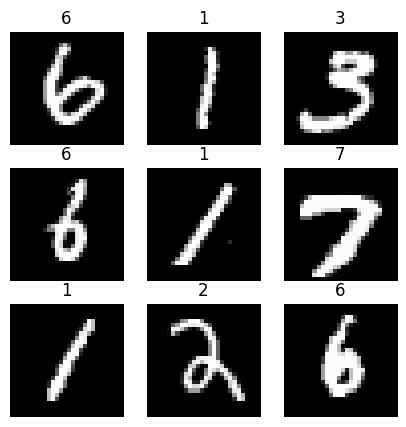

In [ ]:
fig = plt.figure(figsize = (5,5));

columns = 3
rows = 3

for i in range(1, columns*rows +1):
    img_x = np.random.randint(len(train_dataset));
    img = train_dataset[img_x][0][0,:,:] # 3차원 배열 생성
    ### 시각화
    fig.add_subplot(rows, columns, i)
    plt.title(train_dataset[img_x][1])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

# **2. 모델 네크워크 정의**

In [ ]:
class MNISTDNN(nn.Module):
    ### Initialization
    # layer 정의
    def __init__(self):
        super(MNISTDNN,self).__init__()
        self.fc1 = nn.Linear(in_features = 784, out_features = 512)
        self.fc2 = nn.Linear(in_features = 512, out_features = 256)
        self.fc3 = nn.Linear(in_features = 256, out_features = 128)
        # 최종 출력층은 분류하려는 클래스의 수와 동일하게 설정
        self.fc4 = nn.Linear(in_features = 128, out_features = 10)

        self.drop = nn.Dropout(0.1)

    ### 순전파 적용
    def forward(self,input_data):
        out = input_data.view(-1, 784) # CNN layer 활용 x -> 2차원 tensor로 데이터 변환

        # 은닉층에는 ReLU 활성화 함수 적용
        out = F.relu(self.fc1(out))
        out = self.drop(out)

        out = F.relu(self.fc2(out))
        out = self.drop(out)

        out = F.relu(self.fc3(out))

        # 출력층은 softmax 활성화 함수 적용
        out = F.log_softmax(self.fc4(out), dim = 1) # out = self.fc4(out) -> CrossEntropyLoss()

        return out

# **3. 학습 및 평가**

## **3-1. 모델 객체 생성**

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary

model = MNISTDNN().to(device) # GPU 사용을 위해 model 객체를 device에 올리는 과정
summary(model, input_size = (1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
MNISTDNN                                 [1, 10]                   --
├─Linear: 1-1                            [1, 512]                  401,920
├─Dropout: 1-2                           [1, 512]                  --
├─Linear: 1-3                            [1, 256]                  131,328
├─Dropout: 1-4                           [1, 256]                  --
├─Linear: 1-5                            [1, 128]                  32,896
├─Linear: 1-6                            [1, 10]                   1,290
Total params: 567,434
Trainable params: 567,434
Non-trainable params: 0
Total mult-adds (M): 0.57
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.27
Estimated Total Size (MB): 2.28

## **3-2. 손실함수/옵티마이저 정의**

In [ ]:
learning_rate = 0.0005
optimizer = optim.SGD(model.parameters(), lr = learning_rate)
loss_fn = nn.NLLLoss() # - (y1 * log p1 + y2 * log p2 + ...) -> p = softmax probability / log p = log_softmax probability

## **3-3. 학습**

In [ ]:
### Training을 위한 함수

def train(dataloader, model,loss_fn,optimizer):
  model.train() # 학습 모드

  train_loss = 0

  for batch,(X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # 예측 및 loss 계산
    pred = model(X)
    loss = loss_fn(pred, y)

    optimizer.zero_grad() # 가중치 초기화
    loss.backward() # 역전파
    optimizer.step() # 가중치 업데이트

    train_loss += loss.item()

  avg_loss = train_loss / len(dataloader)

  return avg_loss

In [ ]:
train_losses = [] # 학습 곡선을 그리기 위해 손실 값을 저장할 리스트

epochs = 100

for t in range(epochs):
    train_loss = train(train_loader, model, loss_fn, optimizer)
    train_losses.append(train_loss)
    print(f"Epoch {t + 1} >> Train Loss: {train_loss:.6f}")

print('끝!')

Epoch 1 >> Train Loss: 2.294446
Epoch 2 >> Train Loss: 2.270772
Epoch 3 >> Train Loss: 2.238869
Epoch 4 >> Train Loss: 2.190149
Epoch 5 >> Train Loss: 2.106405
Epoch 6 >> Train Loss: 1.954124
Epoch 7 >> Train Loss: 1.693504
Epoch 8 >> Train Loss: 1.364491
Epoch 9 >> Train Loss: 1.080531
Epoch 10 >> Train Loss: 0.887410
Epoch 11 >> Train Loss: 0.764418
Epoch 12 >> Train Loss: 0.680753
Epoch 13 >> Train Loss: 0.620034
Epoch 14 >> Train Loss: 0.576237
Epoch 15 >> Train Loss: 0.540480
Epoch 16 >> Train Loss: 0.510975
Epoch 17 >> Train Loss: 0.485001
Epoch 18 >> Train Loss: 0.466714
Epoch 19 >> Train Loss: 0.450487
Epoch 20 >> Train Loss: 0.435884
Epoch 21 >> Train Loss: 0.423752
Epoch 22 >> Train Loss: 0.409646
Epoch 23 >> Train Loss: 0.399045
Epoch 24 >> Train Loss: 0.391024
Epoch 25 >> Train Loss: 0.383049
Epoch 26 >> Train Loss: 0.375415
Epoch 27 >> Train Loss: 0.367695
Epoch 28 >> Train Loss: 0.361916
Epoch 29 >> Train Loss: 0.355240
Epoch 30 >> Train Loss: 0.349201
Epoch 31 >> Train L

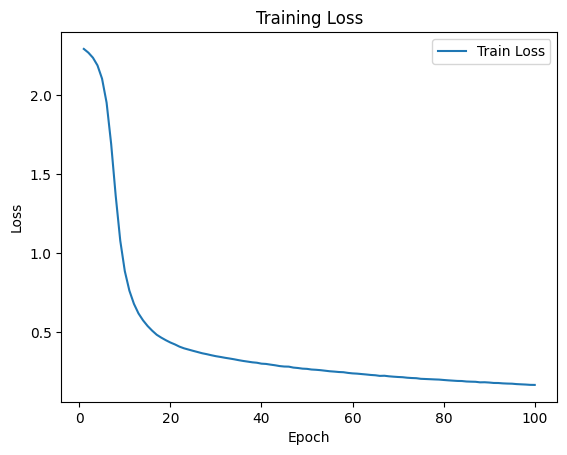

In [ ]:
plt.figure()
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

## **3-4. 평가**

In [ ]:
### Test를 위한 함수

def test(dataloader, model, loss_fn): # -> validation
    model.eval() # 평가 모드

    size = len(dataloader.dataset) # 데이터 셋의 크기
    num_batches = len(dataloader)

    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            # 예측 및 loss 계산
            pred = model(X)
            loss = loss_fn(pred, y)

            test_loss += loss.item()
            correct += (pred.argmax(dim=1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size

    print(f'Test Error: \n Accuracy: {(100 * correct):>0.1f}%. Avg loss: {test_loss:.8f}\n')

    return test_loss

In [ ]:
test_loss = test(test_loader, model, loss_fn)

Test Error: 
 Accuracy: 95.4%. Avg loss: 0.15133037

